# The Kalman filter

\begin{align}
\mathbf{x}_{t + 1} &= \mathbf{A}\mathbf{x}_t + \mathbf{w}_t, && \text{ where } \mathbf{w}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}), \\
      \mathbf{y}_t &= \mathbf{C}\mathbf{x}_t + \mathbf{v}_t, && \text{ where } \mathbf{v}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}).
\end{align}

\begin{align}
\mathbf{m}_t^t &= \mathbf{m}_t^{t - 1} + \mathbf{K}_t (\mathbf{y}_t - \mathbf{C}\mathbf{m}_t^{t - 1})\\
\mathbf{V}_t^t &= \mathbf{V}_t^{t - 1} - \mathbf{K}_t \mathbf{C} \mathbf{V}_t^{t - 1}\\
\mathbf{K}_t &= \mathbf{V}_t^{t - 1} \mathbf{C}^\top (\mathbf{R} + \mathbf{C}\mathbf{V}_t^{t - 1}\mathbf{C}^\top)^\top
\end{align}

In [205]:
import numpy as np
from matplotlib import pyplot as plt

In [206]:
def sample_trajectory(m0, S0, A, Q, C, R, num_points):
    
    x = np.random.multivariate_normal(mean=m0, cov=S0)
    y_mean = np.dot(C, x)
    y = np.random.multivariate_normal(mean=y_mean, cov=R)
    
    xs = np.array([x])
    y_means = np.array([y_mean])
    ys = np.array([y])
    
    for i in range(num_points - 1):
        
        x = np.random.multivariate_normal(mean=np.dot(A, x), cov=Q)
        y_mean = np.dot(C, x)
        y = np.random.multivariate_normal(mean=y_mean, cov=R)
        
        xs = np.concatenate([xs[:], x[None, :]], axis=0)
        y_means = np.concatenate([y_means[:], y_mean[None, :]], axis=0)
        ys = np.concatenate([ys[:], y[None, :]], axis=0)
    
    return xs, y_means, ys

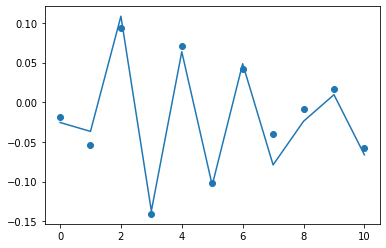

In [362]:
x_dim = 3
y_dim = 1

m0 = np.zeros(x_dim,)
S0 = 0.1 * np.eye(x_dim)

np.random.seed(0)

A = (2 * np.random.rand(x_dim, x_dim) - 1) / x_dim
Q = 0.1 ** 2 * np.eye(x_dim)

C = 2 * np.random.rand(y_dim, x_dim) - 1
R = 2e-2 ** 2 * np.eye(y_dim)

num_points = 11

xs, y_means_true, ys = sample_trajectory(m0=m0, S0=S0, A=A, Q=Q, C=C, R=R, num_points=num_points)

plt.plot(np.arange(num_points), y_means_true[:, 0])
plt.scatter(np.arange(num_points), ys[:, 0])

\begin{align}
\mathbf{x}_{t + 1} &= \mathbf{A}\mathbf{x}_t + \mathbf{w}_t, && \text{ where } \mathbf{w}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}), \\
      \mathbf{y}_t &= \mathbf{C}\mathbf{x}_t + \mathbf{v}_t, && \text{ where } \mathbf{v}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}).
\end{align}

\begin{align}
\mathbf{m}_t^t &= \mathbf{m}_t^{t - 1} + \mathbf{K}_t (\mathbf{y}_t - \mathbf{C}\mathbf{m}_t^{t - 1})\\
\mathbf{V}_t^t &= \mathbf{V}_t^{t - 1} - \mathbf{K}_t \mathbf{C} \mathbf{V}_t^{t - 1}\\
\mathbf{K}_t &= \mathbf{V}_t^{t - 1} \mathbf{C}^\top (\mathbf{R} + \mathbf{C}\mathbf{V}_t^{t - 1}\mathbf{C}^\top)^\top
\end{align}

In [363]:
def forward(ys, m0, S0, A, Q, C, R):
    
    m_t_1_t = m0
    V_t_1_t = S0

    ms = []
    Vs = []
    
    y_m_pred = []
    y_v_pred = []
    
    y_m_filt = []
    y_v_filt = []
    
    for t in range(num_points):
        
        y_diff = ys[t] - np.dot(C, m_t_1_t)
        
        m_t_t = m_t_1_t + kalman_dot(array=y_diff, V_t_1_t=V_t_1_t, C=C, R=R)
        
        KC = kalman_dot(array=C, V_t_1_t=V_t_1_t, C=C, R=R)
        V_t_t = V_t_1_t - np.dot(KC, V_t_1_t)
        
        ms.append(m_t_t)
        Vs.append(V_t_t)
        
        y_m_pred.append(np.dot(C, np.dot(A, m_t_1_t)))
        y_v_pred.append(np.dot(C, np.dot(np.dot(A, np.dot(V_t_1_t, A.T)) + Q, C.T)) + R)
        
        y_m_filt.append(np.dot(C, m_t_t))
        y_v_filt.append(np.dot(C, np.dot(V_t_t, C.T)) + R)
    
        m_t_1_t = np.dot(A, m_t_t)
        V_t_1_t = np.dot(A, np.dot(V_t_t, A.T)) + Q
        

    ms = np.array(ms)
    Vs = np.array(Vs)
    
    y_m_pred = np.array(y_m_pred)
    y_v_pred = np.array(y_v_pred)
    y_m_filt = np.array(y_m_filt)
    y_v_filt = np.array(y_v_filt)
    
    return ms, Vs, y_m_pred, y_v_pred, y_m_filt, y_v_filt


def kalman_dot(array, V_t_1_t, C, R):
    
    R_CVCT = R + np.dot(C, np.dot(V_t_1_t, C.T))
    R_CVCT_inv_array = np.linalg.solve(R_CVCT, array)
    
    K_y = np.dot(V_t_1_t, np.dot(C.T, R_CVCT_inv_array))
    
    return K_y

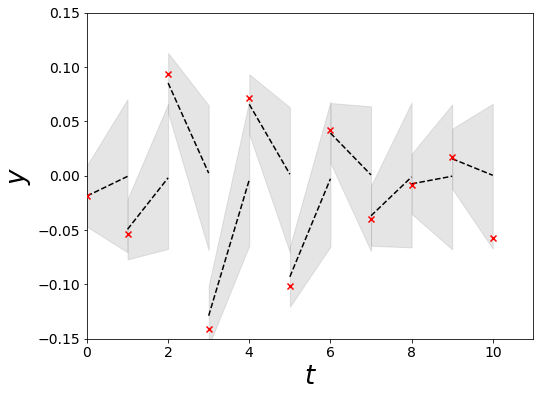

In [364]:
ms, Vs, y_m_pred, y_v_pred, y_m_filt, y_v_filt = forward(ys=ys, m0=m0, S0=S0, A=A, Q=Q, C=C, R=R)

t = np.arange(num_points)
t_rep = np.arange(2 * num_points) // 2

plt.figure(figsize=(8, 6))
plt.scatter(t, ys[:, 0], marker='x', color='red', zorder=3)

for i in range(num_points - 1):
    plt.plot([t[i], t[i + 1]], [y_m_filt[i, 0], y_m_pred[i + 1, 0]], '--', color='black', zorder=2)
    
    plt.fill_between([t[i], t[i + 1]],
                     [y_m_filt[i, 0] - y_v_filt[i, 0, 0] ** 0.5,
                      y_m_pred[i, 0] - y_v_pred[i, 0, 0] ** 0.5],
                     [y_m_filt[i, 0] + y_v_filt[i, 0, 0] ** 0.5,
                      y_m_pred[i, 0] + y_v_pred[i, 0, 0] ** 0.5],
                     color='gray',
                     alpha=0.2,
                     zorder=1)

plt.xticks(np.arange(0, num_points + 1, 2), fontsize=14)
plt.yticks(np.linspace(-0.15, 0.15, 7), fontsize=14)

plt.xlim([0, num_points])
plt.ylim([-0.15, 0.15])

plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.show()

## Part of the backward equations

\begin{align}
\mathbf{x}_{t} | \mathbf{x}_{t + 1}, \mathbf{y}_1^t &\sim \mathcal{N}(\mathbf{D}(\mathbf{A}^\top\mathbf{Q}^{-1}\boldsymbol{\mu}_{t + 1} + \mathbf{S}_t^{-1} \mathbf{m}_t), \boldsymbol{\Sigma}_{t + 1} + \mathbf{D} \mathbf{A}^\top \mathbf{Q}^{-1}\boldsymbol{\Sigma}_{t + 1}\mathbf{Q}^{-1}\mathbf{A}\mathbf{D}).
\end{align}

In [365]:
def backward(ms, Vs, A, Q):
    
    # Arrays for storing smoothed posterior
    mus = np.array([ms[-1]])
    Sigmas = np.array([Vs[-1]])
    
    T = ms.shape[0]
    
    for t in range(T - 2, -1, -1):
        
        # Compute D matrix
        D = Q + np.dot(A.T, np.dot(Vs[t], A))
        D = np.linalg.solve(D, np.dot(A, Vs[t]))
        D = np.dot(Vs[t], np.dot(A.T, D))
        D = Vs[t] - D
        
        # Compute mean
        AT_Qinv_mu_t = np.dot(A.T, np.linalg.solve(Q, mus[0]))
        V_t_t_inv_m = np.linalg.solve(Vs[t], ms[t])
        mu_t = np.dot(D, AT_Qinv_mu_t + V_t_t_inv_m)
        
        # Compute variance
        Q_inv_AD = np.dot(Q, np.dot(A, D))
        Sigma_t = Sigmas[0] + np.dot(Q_inv_AD.T, np.dot(Sigmas[0], Q_inv_AD))
        
        # Update mu and Sigma (smoothed posterior) arrays
        mus = np.concatenate([mu_t[None, :], mus], axis=0)
        Sigmas = np.concatenate([Sigma_t[None, :], Sigmas], axis=0)
        
    return mus, Sigmas

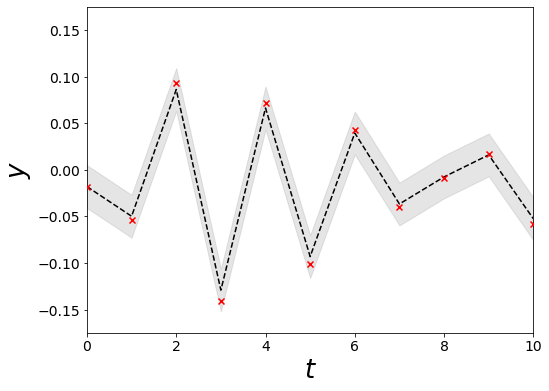

In [366]:
mus, Sigmas = backward(ms=ms, Vs=Vs, A=A, Q=Q)

t = np.arange(num_points)

plt.figure(figsize=(8, 6))
plt.scatter(t, ys[:, 0], marker='x', color='red', zorder=3)

y_smooth_mean = np.dot(C, mus.T)[0, :]
y_smooth_var = np.dot(C, np.dot(Sigmas, C.T) + R)[:, 0, 0]

plt.plot(t, y_smooth_mean, '--', color='black', zorder=2)
plt.fill_between(t,
                 y_smooth_mean - y_smooth_var ** 0.5,
                 y_smooth_mean + y_smooth_var ** 0.5,
                 color='gray',
                 alpha=0.2,
                 zorder=1)

plt.xticks(np.arange(0, num_points + 1, 2), fontsize=14)
plt.yticks(np.linspace(-0.15, 0.15, 7), fontsize=14)

plt.xlim([0, num_points - 1])
plt.ylim([-0.175, 0.175])

plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.show()

## Smoothing with covariances